In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.pca import perform_pca
from util.k_folds_cross_val import k_folds_x_val, get_cmat, get_metrics
from util.hpo import gridSearchHPO
from util.forward_select import forward_select, forward_select_and_fit

from sklearn import svm
from sklearn import metrics
import sklearn as skl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [30]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

# Load all data
train_data = pd.read_csv("../data/training_labse.csv")
test_data = pd.read_csv("../data/test_labse.csv")
validation_data = pd.read_csv("../data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

In [31]:
X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [32]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [33]:
X_train_used = X_train_unreduced
X_val_used = X_val_unreduced
X_test_used = X_test_unreduced
X_train_val_used = X_train_val_unreduced 
X_val_test_used = X_val_test_unreduced

# Principal Component Analysis (PCA)

In [34]:
TARGET_EXPLAINED_VARIANCE = 0.95

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_reduced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

180 components for training


In [35]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [36]:
X_train_used = X_train_reduced
X_val_used = X_val_reduced
X_test_used = X_test_reduced
X_train_val_used = X_train_val_reduced 
X_val_test_used = X_val_test_reduced

# SVM

In [37]:
svm_classifier = svm.SVC(max_iter=-1)

# Grid Search Hyperparameter Optimization

In [38]:
svm_search_space={
    'C': [1],
    'kernel': ['poly'], # poly - 'rbf', 'linear', 'sigmoid' 
    'degree': [3],  # 3
    'gamma': ['scale'], #'auto',  1, 0.1, 0.01, 0.001, 0.0001, 
    'coef0': [0.1], 
    'shrinking': [True], 
    'probability': [False], 
    'tol': [0.1],  
    'class_weight': [None], 
    'decision_function_shape': ['ovr'], # 'ovo'
}

#Train the model using the training sets
svm_classifier.fit(X_train_used, Y_train)

gridsearch_svm = gridSearchHPO(svm_classifier, svm_search_space)

In [39]:
gridsearch_svm.fit(X_train_used, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise', estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1], 'class_weight': [None], 'coef0': [0.1],
                         'decision_function_shape': ['ovr'], 'degree': [3],
                         'gamma': ['scale'], 'kernel': ['poly'],
                         'probability': [False], 'shrinking': [True],
                         'tol': [0.1]},
             scoring='accuracy', verbose=3)

In [40]:
print("Best Score: {}".format(gridsearch_svm.best_score_))
print("Best params: {}".format(gridsearch_svm.best_params_))

Best Score: 0.6464375
Best params: {'C': 1, 'class_weight': None, 'coef0': 0.1, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': False, 'shrinking': True, 'tol': 0.1}


(0.2905, 0.13078690430065865)


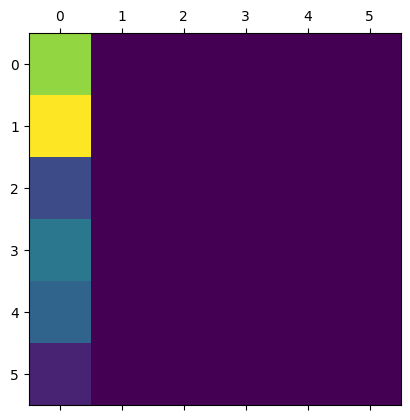

In [41]:
cmat = get_cmat(gridsearch_svm, X_test_used, Y_test)
print(get_metrics(gridsearch_svm, X_test_used, Y_test))
plt.matshow(cmat)
plt.show()